> ### EEE4423: Deep Learning Lab

# LAB \#10: Image Style Transfer

<h4><div style="text-align: right"> Due date: May 13, 2022  </div> <br>
<div style="text-align: right"> Please upload your file @ LearnUs by 9 AM in the form of [ID_Name_Lab10.ipynb]. </div></h4>

### *Instructions:*
- Write a program implementing a particular algorithm to solve a given problem.   
- <span style="color:red">**Report and discuss your results. Analyze the algorithm, theoretically and empirically.**</span> 
- Each team must write their own answers and codes (<span style="color:red">**if not you will get a F grade**</span>).


<h2><span style="color:blue">[2018142192] [최순규]</span> </h2>

In [19]:
import datetime
print("This code is written at " + str(datetime.datetime.now()))

This code is written at 2023-05-11 00:24:48.397886




# Neural Stylization with Pytorch
## Introduction


<img src="http://drive.google.com/uc?export=view&id=1crqAv5aoJ3uMSDFT99l6VuzY3VUlF_C7" alt="no_image" style="width: 900px;"/>

This lab introduces a Neural Algorithm of Artistic Style that can separate and recombine the image content and style of natural images. The algorithm takes two images, a content-image, and a style-image, and generates the optimized image to resemble the content of the content-image and the artistic style of the style-image.


**Main idea**

To transfer the style image $\textit{I}_s$ onto a content image $\textit{I}_c$ we synthesize a new image that simultaneously matches the content representation of $\textit{I}_c$ and the style representation of $\textit{I}_s$ (Fig). Thus we jointly minimize the distance of the feature representations of a white noise image from the content representation of the photograph in one layer and the style representation of the painting defined on a number of layers of the Convolutional Neural Network.
<img src="http://drive.google.com/uc?export=view&id=1BhfqqQEMn3AyHpc6fB-shQDlU-tQeoLz" alt="no_image" style="width: 900px;"/>

In [1]:
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

from PIL import Image
import numpy as np

from torchvision import datasets
from torch.utils.data import DataLoader

warnings.filterwarnings("ignore")

**Style and content image**

In [2]:
style_img_name = 'dataset-dllab/lab10/style/mosaic.jpg'
content_img_name = 'dataset-dllab/lab10/content/Tuebingen_Neckarfront.jpg'
#style_img_name = '../dataset/lab10/style/mosaic.jpg'
#content_img_name = '../dataset/lab10/content/Tuebingen_Neckarfront.jpg'

In [3]:
style_img = Image.open(style_img_name)    # shape: (391, 470, 3)
content_img = Image.open(content_img_name)    # shape: (768, 1024, 3)

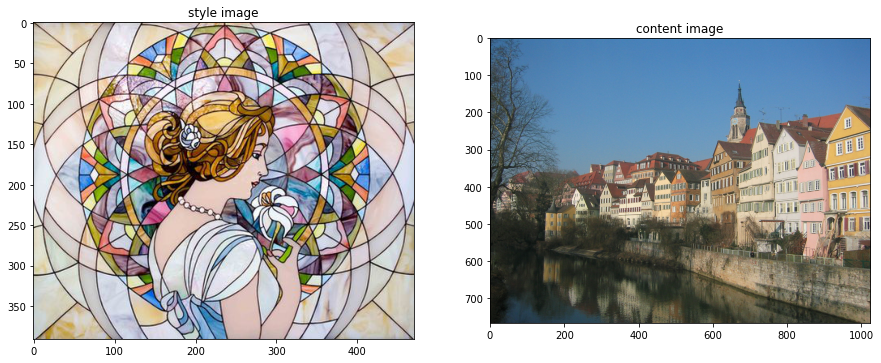

In [4]:
plt.figure(figsize = (15,15))
plt.subplot(1,2,1)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,2,2)
plt.title('content image')
plt.imshow(content_img)

### Style representation

To obtain a representation of the style of an input image, we use a feature space designed to capture texture information. This feature space can be built on top of the filter responses in any layer of the network. It consists of the correlations between the different filter responses, where the expectation is taken over the spatial extent of the feature maps. These feature correlations are given by the Gram matrix $\mathit{G} \in \mathcal{R}^{\mathit{N_l}  \times  \mathit{N_l}}$, where $\mathit{G^l_{ij}}$ is the inner product between the vectorised feature maps $i$ and $j$ in layer $l$:

### <center> ${\mathit{G^l_{ij}} = \sum_{k}{F^l_{ik}F^l_{jk}}}$ </center>

In [5]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

### Deep image representations

In this work we show how the generic feature representations learned by high-performing Convolutional Neural Networks can be used to independently process and manipulate the content and the style of natural images.

The image reperesentations were generated on the basis of the VGG network, which was trained to perform object recognition and localization. We use the feature space provided by the 16 convolutional and 5 pooling layers of the 19-layer VGG network.

In [6]:
import torchvision.models.vgg as vgg

class LossNetwork(torch.nn.Module):
    def __init__(self):
        super(LossNetwork, self).__init__()
        # get vgg network
        self.vgg = vgg.vgg19(pretrained=False)


    def forward(self, x, layer_name):
        output = {}
        for name, module in self.vgg.features._modules.items():    # Ex) '1', ReLU
            x = module(x)                                          # x = ReLU(x)
            if name in layer_name:                                 # if '1' in ['1', '6', '11', '20', '29']
                output[layer_name[name]] = x                       # output['conv1-1'] = x  =>  {'conv1-1': x}
        return output

In [7]:
loss_net = LossNetwork().cuda()
checkpoint = torch.load('./pretrain/lab10/vgg19.pth')
loss_net.vgg.load_state_dict(checkpoint)
for param in loss_net.parameters():
    param.requires_grad = False

Content representation is on layer ‘conv4 2’ and the style representation is on layers ‘conv1 1’, ‘conv2 1’, ‘conv3 1’, ‘conv4 1’ and ‘conv5 1’

In [8]:
style_layer_name = {
    '1': "conv1-1",
    '6': "conv2-1",
    '11': "conv3-1",
    '20': "conv4-1",
    '29': "conv5-1"
}

content_layer_name = {
    '22': "conv4-2"
}

**Pre and post processing for images**

In [9]:

img_size = 512 
prep = transforms.Compose([transforms.Resize(img_size),
    transforms.ToTensor(),    # (H x W x C) -> (C x H x W) & [0, 255] -> [0.0, 1.0]
    transforms.Normalize(mean=[0.40760392, 0.45795686, 0.48501961], #subtract imagenet mean
                        std=[1,1,1]),
])

post = transforms.Compose([
    transforms.Normalize(mean=[-0.40760392, -0.45795686, -0.48501961], #add imagenet mean
                        std=[1,1,1]),
    transforms.Lambda(lambda x: torch.clamp(x,0,1)),    # Set lower and upper bound
    transforms.ToPILImage()    # Inverse of "ToTensor"
])

In [10]:
content = prep(content_img).cuda().unsqueeze(0)    # torch.Size([1, 3, 512, 682])
style = prep(style_img).cuda().unsqueeze(0)    # torch.Size([1, 3, 512, 615])

out_img = content.clone()
out_img.requires_grad = True


criterion = nn.MSELoss()
style_gt = [gram_matrix(f).detach() for f in loss_net(style, style_layer_name).values()]
content_gt = [A.detach() for A in loss_net(content, content_layer_name).values()]

show_iter = 50
optimizer = optim.LBFGS([out_img])
n_iter = [0]

**Hyper parameters**

In [11]:
alpha = 1e0
beta = 1e7
max_iter = 500

**Optimizing image**

In [17]:
while n_iter[0] <= max_iter:

    def closure():
        optimizer.zero_grad()
        
        style_layers = [gram_matrix(f) for f in loss_net(out_img, style_layer_name).values()]
        content_layers = [f for f in loss_net(out_img, content_layer_name).values()]
        
        style_loss = 0
        print(len(style_layers[0]))
        print(style_layers[0])
        print(len(style_gt[0]))
        print(style_gt[0])
        for i in range(len(style_layers)):    
            style_loss += criterion(style_layers[i], style_gt[i])
        
        content_loss = criterion(content_layers[0], content_gt[0])
        
        loss = alpha * content_loss + beta * style_loss
        loss.backward()
        n_iter[0]+=1
        #print loss
        if n_iter[0]%show_iter == (show_iter-1):
            print('Iteration: %d, loss: %f'%(n_iter[0]+1, loss.item()))

        return loss

    optimizer.step(closure)
    
#display result

1
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0037, 0.0000,  ..., 0.0003, 0.0016, 0.0024],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0003, 0.0000,  ..., 0.0002, 0.0003, 0.0003],
         [0.0000, 0.0016, 0.0000,  ..., 0.0003, 0.0017, 0.0018],
         [0.0000, 0.0024, 0.0000,  ..., 0.0003, 0.0018, 0.0029]]],
       device='cuda:0', grad_fn=<DivBackward0>)
1
tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 3.8245e-03, 0.0000e+00,  ..., 3.2151e-05,
          1.5582e-03, 2.4358e-03],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [0.0000e+00, 3.2151e-05, 0.0000e+00,  ..., 3.8213e-05,
          3.6080e-05, 4.7513e-05],
         [0.0000e+00, 1.5582e-03, 0.0000e+00,  ..., 3.6080e-05,
          1.6189e-03, 1.8570e-03],
         [0.0000e+00, 2.4358e-03,

KeyboardInterrupt: 

**Visualize result images**

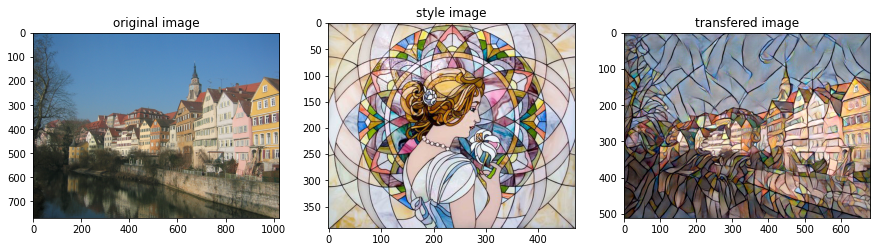

In [14]:
out_img_hr = post(out_img.data[0].cpu().squeeze())

plt.figure(figsize = (15,15))

plt.subplot(1,3,1)
plt.title('original image')
plt.imshow(content_img)
plt.subplot(1,3,2)
plt.title('style image')
plt.imshow(style_img)
plt.subplot(1,3,3)
plt.title('transfered image')
plt.imshow(out_img_hr)
plt.show()



# Perceptual Losses for Style Transfer with Pytorch


**Main idea**

Previous method produces high-quality results, but is computationally expensive since each step of the optimization problem requires a forward and backward pass through the pretrained network. To overcome this computational burden, we train a feed-forward network to quickly approximate solutions to their optimization problem.
<img src="http://drive.google.com/uc?export=view&id=1GFM9l-63SsOFYHP-g2WNN2T6zNDdD09Z" alt="no_image" style="width: 900px;"/>

$\mathcal{L}_{total} = \alpha\sum_{}{\mathcal{l}_{content}} + \beta\sum_{}{\mathcal{l}_{style}} + \gamma\mathcal{l}_{TV}$

- $\mathcal{l}_{content}^{\phi,j} = ||\phi_j(\hat{y}) - \phi_j(y)||^2_2$, $\phi$ represents vgg feature

- $\mathcal{l}_{style}^{\phi,j} = ||G^{\phi}_{j}(\hat{y}) - G^{\phi}_{j}(y)||^2_F$, $G$ represents gram matrix.

- $\mathcal{l}_{TV}(y) = \sum_{i,j}{|y_{i+1,j}-y_{i,j}|+|y_{i,j+1}-y_{i,j}|}$



**Data loader**

In [23]:
data_root = 'dataset-dllab/lab10/train'
image_size = 224
transform = transforms.Compose([
    transforms.Resize(image_size), 
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder(data_root, transform)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

### 1.1 Write code (Image Transform Net) [3 points]

<img src="http://drive.google.com/uc?export=view&id=1OQzOwfRgpncvvBCwUCJbShYQGBElUqjW" alt="no_image" style="width: 400px;"/>

##### Residual block (channel, x)
- Conv 1: $3\times3$ Conv(in: channel, out: channel, padding: 1) with reflection padding
- Instance Norm
- Relu
- Conv 2: $3\times3$ Conv(in: channel, out: channel, padding: 1) with reflection padding
- Instance Norm
- Residual Connection

#### ImageTransformNet
- Conv $9\times9$  (in: 3, out: 32, padding: 4) with reflection padding
- Instance Norm
- Relu
- Conv $3\times3$  (in: 32, out: 64, padding: 1, **stride: 2**) with reflection padding
- Instance Norm
- Relu
- Conv $3\times3$  (in: 64, out:128, padding: 1, **stride: 2**) with reflection padding
- Instance Norm
- Relu
- 5 Residual block(channel: 128)
- $2\times$ Nearest Upsample
- Conv $3\times3$  (in: 128, out:64, padding: 1) with reflection padding
- Instance Norm
- Relu
- **$2\times$ Nearest Upsample**
- Conv $3\times3$  (in: 64, out:32, padding: 1) with reflection padding
- Instance Norm
- Relu
- Conv $9\times9$  (in: 32, out:3, padding: 4) with reflection padding



In [77]:
#Residual block
class Residual(torch.nn.Module):
    def __init__(self, channels):
        super(Residual, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size = 3, stride = 1, padding = 1, padding_mode = 'reflect'),
            nn.InstanceNorm2d(channels),
            nn.ReLU(),
            nn.Conv2d(channels, channels, kernel_size = 3, stride = 1, padding = 1, padding_mode = 'reflect'),
            nn.InstanceNorm2d(channels)
        )
    def forward(self, x):
        return self.conv(x)+x

    
class ImageTransformNet(torch.nn.Module):
    def __init__(self):
        super(ImageTransformNet, self).__init__()
        #downsample
        self.downsample = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size = 9, padding = 4, padding_mode = 'reflect'),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1, padding_mode = 'reflect'), #stride = 2
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1, padding_mode = 'reflect'), #stride = 2
            nn.InstanceNorm2d(128),
            nn.ReLU()
        )
        #residuals
        self.residuals = nn.Sequential(
            Residual(128),
            Residual(128),
            Residual(128),
            Residual(128),
            Residual(128)
        )
        
        #upsample
        self.upsample = nn.Sequential(
            nn.Upsample(scale_factor=2, mode = 'nearest'), #2x Nearest upsample
            nn.Conv2d(128, 64, kernel_size = 3, padding = 1, padding_mode = 'reflect'),
            nn.InstanceNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode = 'nearest'), #2x Nearest upsample
            nn.Conv2d(64, 32, kernel_size = 3, padding = 1, padding_mode = 'reflect'),
            nn.InstanceNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 3, kernel_size = 9, padding = 4, padding_mode = 'reflect')
        )
    def forward(self, x):
        #############
        # CODE HERE #
        #############
        x = self.downsample(x)
        x = self.residuals(x)
        x = self.upsample(x)
        return x


In [78]:
transformer = ImageTransformNet().cuda()

### 1.2 Find style and content representation layers in loss net [1 points]

In [79]:
#we can get number of each layer by investigating vgg19 network layer(loss_net in this code)
style_layer_name = {
    '3': "relu1-2",
    '8': "relu2-2",
    '15': "relu3-3",
    '24': "relu4-3"
}

content_layer_name = {
    '15': "relu3-3"
}

In [80]:
style = transform(style_img).cuda().unsqueeze(0)

#Shape transformation of style_groudtruth
style_gt = []
for f in loss_net(style, style_layer_name).values():
    f = gram_matrix(f).detach()
    f = f.expand((batch_size, -1, -1))
    style_gt.append(f)

**Hyper parameters**

In [81]:
# You may adjust hyper paramters 
alpha = 1e0
beta = 2*1e4
gamma = 1e-5

LR = 1e-3
steps = 2000
optimizer = optim.Adam(transformer.parameters(), LR)

### 1.3 Train the image transformNet [4 points]

- Print total loss, content loss, style loss and total variation loss for every 50 iterations
- Style loss should contain all of the layers listed above
- Use alpha, beta, gamma as coefficient

In [82]:
transformer.train()
n_iter = 0
total_running_loss = 0.0
style_running_loss = 0.0
content_running_loss = 0.0
tv_running_loss = 0.0

class Found(Exception): pass
try:
    while True:
        for x, _ in train_loader:
            optimizer.zero_grad()
            x = x.cuda()
            y_hat = transformer(x) #output of image transform network
            y_hat_features = loss_net(y_hat, style_layer_name) #extract features from vgg
            
            #Calculate style loss
            y_hat_gram = [gram_matrix(f) for f in y_hat_features.values()]
            style_loss = 0
            
            for i in range(4): # 4 is len(style_gt)
                style_loss += criterion(y_hat_gram[i], style_gt[i])
            style_loss = beta*style_loss
            style_running_loss += style_loss
            
            
            
            
            
            #Calculate content_loss
            recon_hat = [f for f in loss_net(y_hat, content_layer_name).values()][0] #
            recon = [f for f in loss_net(x, content_layer_name).values()][0] #
            content_loss = criterion(recon_hat, recon) #calculate MSE loss
            content_loss = alpha*content_loss
            content_running_loss += content_loss
            
            
            
            
            
            #Calculate tv_loss
            diff_i = torch.abs(y_hat[:,:,1:,:-1] - y_hat[:,:,:-1,:-1]) #|y_i+1,j - y_i,j|
            diff_j = torch.abs(y_hat[:,:,:-1,1:] - y_hat[:,:,:-1,:-1]) #|y_i,j+1 - y_i,j|
            
            tv_loss = torch.sum(diff_i+diff_j)
            tv_loss = gamma*tv_loss
            tv_running_loss += tv_loss
            
            
            
            
            # Total loss
            total_loss = content_loss + style_loss + tv_loss
            total_running_loss += total_loss
            
            
            
            #Back propagation & weight update
            total_loss.backward()
            optimizer.step()

            n_iter += 1
            if n_iter % 50 == 0:
                print(f"Iteration: {n_iter}, total loss: {total_running_loss/50}, content loss: {content_running_loss/50}, style loss: {style_running_loss/50}, tv loss: {tv_running_loss/50}")
                total_running_loss = 0.0
                content_running_loss = 0.0
                style_running_loss = 0.0                
                tv_running_loss = 0.0
            if n_iter >= steps: #if exceeds steps
                raise Found

except Found:
    pass
    

Iteration: 50, total loss: 83.55958557128906, content loss: 33.65680694580078, style loss: 47.22457504272461, tv loss: 2.6782116889953613
Iteration: 100, total loss: 56.01626968383789, content loss: 37.11427307128906, style loss: 15.566673278808594, tv loss: 3.3353207111358643
Iteration: 150, total loss: 52.165706634521484, content loss: 35.44647216796875, style loss: 13.32848834991455, tv loss: 3.3907480239868164
Iteration: 200, total loss: 48.9345588684082, content loss: 33.80312728881836, style loss: 11.694422721862793, tv loss: 3.4369993209838867
Iteration: 250, total loss: 47.03302764892578, content loss: 32.40342330932617, style loss: 11.225143432617188, tv loss: 3.404460906982422
Iteration: 300, total loss: 45.67286682128906, content loss: 31.289974212646484, style loss: 11.025449752807617, tv loss: 3.357438087463379
Iteration: 350, total loss: 44.174320220947266, content loss: 30.06598472595215, style loss: 10.790800094604492, tv loss: 3.3175313472747803
Iteration: 400, total l

### 1.4 Discuss the result [2 points]
- Compare the result of neural style with yours
- Adjust the hyper parameter and analyze each result
- Use transform function before and after inference

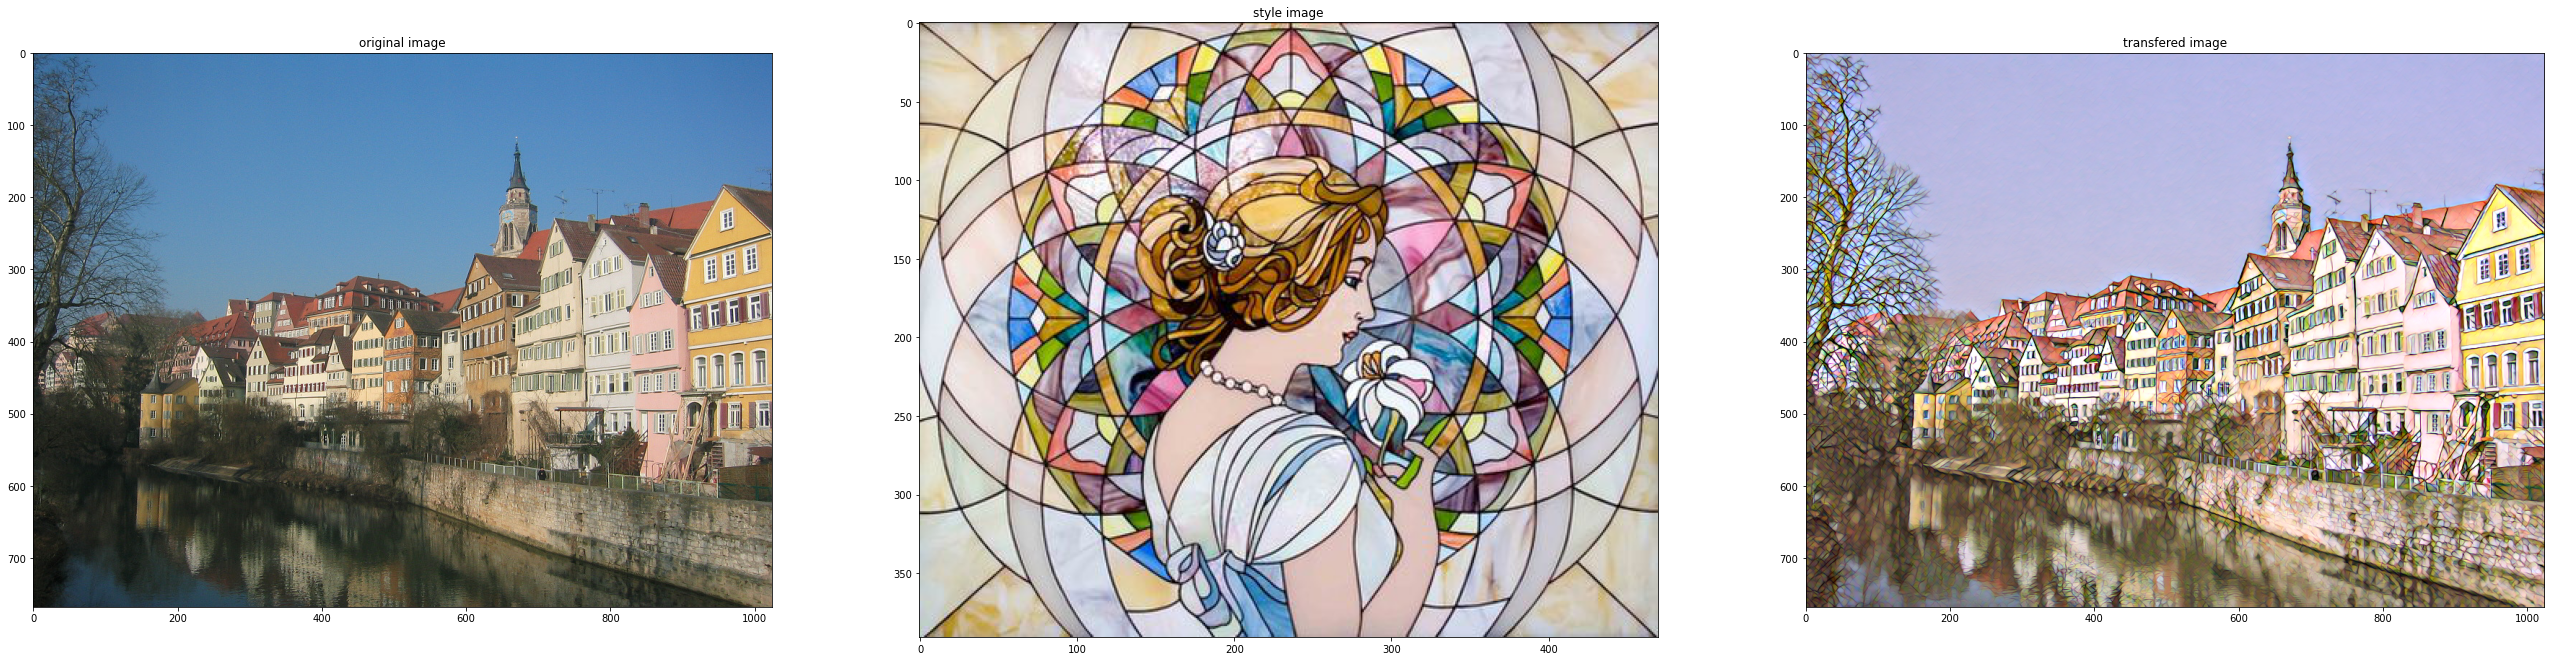

In [83]:
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])])

inverse_transform = transforms.Compose([
    transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
                         std=[1/0.229, 1/0.224, 1/0.255]),
    transforms.Lambda(lambda x: torch.clamp(x,0,1)),
    transforms.ToPILImage()
])

transformed_content_img = test_transform(content_img).cuda().unsqueeze(0)

out_img = transformer(transformed_content_img)
out_img_hr = inverse_transform(out_img.data.cpu().squeeze())

plt.figure(figsize = (45,45)) #make subplot

plt.subplot(1,3,1)
plt.title('original image') #original image
plt.imshow(content_img)
plt.subplot(1,3,2)
plt.title('style image') #style image
plt.imshow(style_img)
plt.subplot(1,3,3)
plt.title('transfered image') #transfered image
plt.imshow(out_img_hr)
plt.show()



### *References*
[1] Neural Transfer Pytorch Tutorial (https://pytorch.org/tutorials/advanced/neural_style_tutorial.html)

# Discussion

이번 주차에는 Image style transfer를 학습하였으며 Perceptual loss를 통한 Image Transformation network를 만드는 실험을 수행하였다.

본래 **Image Style Transfer Using Convolutional Neural Networks** 논문에서는 white noise에 content loss, style loss를 기반으로 학습을 시켜나가며
두 그림 각각의 Content와 Style을 닮은 그림을 생성하는 모델을 소개하였다.

이번에 구현한 network는**Perceptual Losses for Real-Time Style Transfer and Super-Resolution**에서 소개된 방식이다. 여기에서는 White noise를 학습시키는 방식이 아닌,
image style transfer를 돕는 자체적인 인공신경망을 하나 더 만드는 방식으로 style transfer를 구현하고
그 결과 속도와 품질을 향상시킬 수 있었다.

feature reconstruction loss의 경우 논문에서는 relu2_2에서 얻어와 계산하였지만 이번 실험의 경우 주어진 대로 relu 3_3에서 값을 얻어와 reconstruction loss를 계산하였다.

a(알파), b(베타) hyperparameter 값에 따라 이미지가 content 와 style이 학습되는 비중을 조절할 수 있다.
기존에 주어진 hyperparameter를 따라도 어느정도 style이 입혀지는 것을 확인할 수 있었지만 조금 더 이를 확실하게 보여주기 위해
style의 hyperparameter를 두 배 증가시켜 결과를 출력하였다. 이 경우 이미지에 style이 더 강하게 입혀지는 모습을 확인할 수 있었다.

learning_rate나 mini_batch size등은 특별히 조절하지 않고 논문의 값을 따라 사용하였다.